In [7]:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
from PIL import Image    
import os, glob
import sys
import json
import datetime
import numpy as np
import skimage.draw
import shutil
import tensorflow as tf
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize as vis
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt


class GenericDataset(utils.Dataset):

    def load_item(self, dataset_dir, subset):
        """Load a subset of dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys



        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        classes = []

        all_files = dict()
        for _ in os.listdir(dataset_dir):
            all_files[".".join(_.split(".")[:-1])] = _ 
        for a in annotations:
            
            polygons=[]
            objects=[]
            for r in a['regions']:
                polygons.append(r['shape_attributes'])
                objects.append(r['region_attributes'])

            class_ids = [int(n['class']) for n in objects]
            image_path = dataset_dir + "/" + all_files[a['filename'] ]
            image = Image.open(image_path)
            width, height = image.size
            
            
            self.add_image(
                "class",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)

            for r in a['regions']:

                _class = r['region_attributes']['class']
                if _class not in classes:
                    classes += [_class]

        for i in range(len(classes)):
            self.add_class("class", i+1,  str(_class))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1


        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids



Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



In [8]:
"""Build Dataset."""
print("Loading Training Dataset...")
DATASET_DIR = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing/"

# Training dataset.
dataset_train = GenericDataset()
dataset_train.load_item(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
print("Loading Validation Dataset...")
dataset_val = GenericDataset()
dataset_val.load_item(DATASET_DIR, "val")
dataset_val.prepare()

Loading Training Dataset...
3780
Loading Validation Dataset...
450


In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

2


NameError: name 'visualize' is not defined

# Visualizing Dataset

449
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1


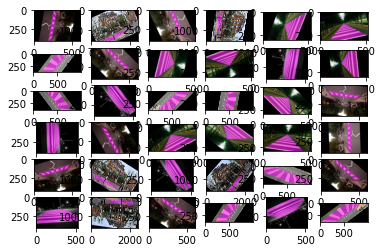

In [13]:
import random

count = 0
rows, cols      = 6, 6
class_ids = [i for i in range(dataset_val.num_images - 1)]


print(len(class_ids))
ids_list  = random.sample(class_ids, rows * cols)

for id_ in ids_list: 
    count += 1
    id_ -= 1
    
    image = dataset_val.load_image(id_)
    mask, class_id= dataset_val.load_mask(id_)
    _, _, masks_num = mask.shape
    # Ploting Masks
    for i in range(masks_num):
        mask_ = vis.apply_mask(image, mask[:,:,i], [1,2,3])
    
    plt.subplot(rows, cols, count)
    plt.imshow(mask_)
plt.show()

In [4]:
from mrcnn.config import Config
WEIGHTS_DIR = "/media/sohaib/additional_/maskrcnn/weights/"

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes + 1
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10


config = GenericConfig(2, 100)


model = modellib.MaskRCNN(mode="training", config=config, model_dir=WEIGHTS_DIR)
                



Initilizing Config
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [5]:


transfer_weights_path = "mask_rcnn_448_class_0701.h5"
model.load_weights(transfer_weights_path, by_name=False, exclude=None)

model.train(dataset_train, dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=1000,
        layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /media/sohaib/additional_/maskrcnn/weights/448_class20210828T2233/mask_rcnn_448_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


KeyboardInterrupt: 